# Lab | Random Forests

## EDA

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
numerical = pd.read_csv('./files_for_lab/numerical.csv')
categorical = pd.read_csv('./files_for_lab/categorical.csv')
target = pd.read_csv('./files_for_lab/target.csv')
print('Numericals shape:', numerical.shape)
print('Categoricals shape:', categorical.shape)
print('Target shape:', target.shape)

Numericals shape: (95412, 315)
Categoricals shape: (95412, 22)
Target shape: (95412, 2)


In [3]:
num_nas = pd.DataFrame(numerical.isna().sum()).T
num_nas = num_nas[(num_nas!=0).any(axis=1)]
num_nas

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2


In [4]:
categorical_nas = pd.DataFrame(categorical.isna().sum()).T
categorical_nas = categorical_nas[(categorical_nas!=0).any(axis=1)]
categorical_nas

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM


In [5]:
target.isna().sum()

TARGET_B    0
TARGET_D    0
dtype: int64

- No nas, but we have 315 numerical columns, so we will select the best with KBest. We will also encode the categoricals and concatenate them with the result.

In [6]:
categorical = pd.get_dummies(categorical, drop_first=True)

In [7]:
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(numerical)
numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical.columns)
numerical_scaled_df.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,0.000000,0.608247,0.666667,1.000000,0.000000,0.000000,0.393939,0.343434,0.181818,0.101010,0.020202,0.011494,0.555556,0.010051,0.011108,0.009378,0.0,0.353535,0.656566,0.474747,0.535354,0.929293,0.010101,0.0,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.113402,0.0,0.000000,0.000000,0.464286,0.571429,0.607143,0.476190,0.595238,0.642857,0.333333,0.313131,0.424242,0.272727,0.111111,0.141414,0.181818,0.171717,0.131313,0.111111,0.151515,0.121212,0.111111,0.343434,0.252525,0.181818,0.262626,0.101010,0.232323,0.181818,0.333333,0.494949,0.282828,0.121212,0.040404,0.616162,0.070707,0.164384,0.191919,0.304615,0.394286,0.979798,0.959596,0.020202,0.020202,0.000000,0.000000,0.070707,0.070707,0.000000,0.079833,0.105833,0.230769,0.153846,0.868687,0.141414,0.969697,0.040404,0.070707,0.383838,0.808081,0.707071,0.323232,0.848485,0.161616,0.060606,0.04,0.050505,0.090909,0.151515,0.030303,0.226667,0.505051,0.252525,0.000000,0.000000,0.000000,0.020202,0.070707,0.131313,0.272727,0.474747,0.000000,0.010101,0.616162,0.682353,0.677778,0.245902,0.100,0.020202,0.000000,0.000000,0.141414,0.010101,0.000000,0.000000,0.020202,0.050505,0.171717,0.737374,0.000000,0.271889,0.774120,0.204667,0.212000,0.232667,0.252000,0.073818,0.131313,0.232323,0.232323,0.232323,0.151515,0.010101,0.00,0.000000,0.010101,0.040404,0.252525,0.242424,0.262626,0.171717,0.020202,0.00,0.00000,0.020202,0.282828,0.040404,0.515152,0.010101,0.464646,0.545455,0.030303,0.888889,0.080808,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.040404,0.010101,0.131313,0.155556,0.210526,0.020202,0.454545,0.565657,0.646465,0.505051,0.646465,0.444444,0.626263,0.535354,1.000000,0.0,0.000000,0.090909,0.030303,0.080808,0.131313,0.090909,0.000000,0.054545,0.090909,0.030303,0.151515,0.191919,0.050505,0.040404,0.030303,0.0,0.030303,0.414141,0.010101,0.000000,0.070707,0.131313,0.060606,0.050505,0.000000,0.059701,0.090909,0.040404,0.010101,0.030303,0.101010,0.020202,0.010101,0.070707,0.787879,0.020202,0.000000,0.705882,0.161616,0.101010,0.393939,0.212121,0.216216,0.040404,0.030303,0.051546,0.202020,0.100000,0.263889,0.040404,0.000000,0.000000,0.000000,0.181818,0.393939,0.000000,0.343434,0.232323,0.181818,0.161616,0.012048,0.040404,0.000000,0.250000,0.000000,0.000000,0.050505,0.018182,0.000000,0

- X / y split to use kbest to select best numerical variables later

In [8]:
X = numerical_scaled_df.copy()
y = target['TARGET_B']

In [9]:
kbest = SelectKBest(chi2, k=10)
kbest.fit(X,y)
X_new = kbest.transform(X)
best_num_columns = [X.columns[index] for index, value in enumerate(kbest.get_support().tolist()) if value==True]
num_best = pd.DataFrame(X_new, columns=best_num_columns)
num_best.head()

,ETH2,HVP1,HVP2,HVP3,HVP4,HVP6,RP1,RP2,CARDGIFT,RFA_2F
0,0.010101,0.020202,0.070707,0.131313,0.272727,0.000000,0.020202,0.050505,0.341463,1.000000
1,0.000000,0.979798,0.989899,0.989899,0.989899,0.949495,0.919192,0.919192,0.024390,0.333333
2,0.020202,0.000000,0.010101,0.060606,0.181818,0.000000,0.000000,0.020202,0.341463,1.000000
3,0.000000,0.101010,0.252525,0.505051,0.696970,0.101010,0.010101,0.080808,0.170732,1.000000
4,0.989899,0.000000,0.010101,0.020202,0.161616,0.000000,0.252525,0.585859,0.195122,0.333333


- Concat best numerical columns with encoded categoricals (categoricals will also be scaled first as otherwise they would be off scale compared to numericals)

In [10]:
scaler = MinMaxScaler()
categorical_scaled = scaler.fit_transform(categorical)
categorical_scaled_df = pd.DataFrame(categorical_scaled, columns=categorical.columns)
categorical_scaled_df.head()

data = pd.concat([num_best, categorical_scaled_df], axis=1)
data.reset_index(drop=True, inplace=True)
data

,ETH2,HVP1,HVP2,HVP3,HVP4,HVP6,RP1,RP2,CARDGIFT,RFA_2F,CLUSTER,DATASRCE,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,STATE_FL,STATE_GA,STATE_IL,STATE_IN,STATE_MI,STATE_MO,STATE_NC,STATE_TX,STATE_WA,STATE_WI,STATE_other,HOMEOWNR_U,GENDER_M,GENDER_other,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U
0,0.010101,0.020202,0.070707,0.131313,0.272727,0.000000,0.020202,0.050505,0.341463,1.000000,0.673077,1.0,0.333333,0.428571,0.0,0.381443,1.000000,0.772727,0.636364,0.863636,0.090909,0.0,1.000000,0.927083,0.909091,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.979798,0.989899,0.989899,0.989899,0.949495,0.919192,0.919192,0.024390,0.333333,0.250000,1.0,0.000000,0.785714,0.0,0.536082,0.090909,0.818182,0.818182,0.909091,1.000000,0.0,1.000000,0.968750,0.818182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.020202,0.000000,0.010101,0.060606,0.181818,0.000000,0.000000,0.020202,0.341463,1.000000,0.807692,1.0,0.333333,0.500000,0.0,0.000000,0.090909,0.727273,0.909091,0.772727,0.545455,0.0,1.000000,0.937500,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.000000,0.101010,0.252525,0.505051,0.696970,0.101010,0.010101,0.080808,0.170732,1.000000,0.826923,1.0,0.333333,0.285714,0.0,0.288660,0.000000,0.545455,0.909091,0.863636,0.909091,0.0,1.000000,0.906250,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.989899,0.000000,0.010101,0.020202,0.161616,0.000000,0.252525,0.585859,0.195122,0.333333,0.288462,1.0,0.333333,0.214286,0.0,0.206186,0.000000,0.818182,0.818182,0.954545,0.000000,0.5,0.000000,0.822917,0.181818,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,0.101010,0.020202,0.101010,0.494949,0.737374,0.000000,0.696970,0.848485,0.000000,0.000000,0.500000,1.0,0.333333,0.928571,0.0,0.000000,0.090909,0.954545,0.090909,0.954545,0.090909,0.5,0.090909,1.000000,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
95408,0.030303,0.181818,0.717172,0.888889,0.919192,0.050505,0.161616,0.262626,0.000000,0.000000,0.442308,1.0,0.000000,0.928571,0.0,0.515464,0.000000,0.954545,0.181818,0.954545,0.181818,0.5,0.181818,1.000000,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95409,0.141414,0.000000,0.000000,0.000000,0.010101,0.000000,0.030303,0.343434,0.097561,0.666667,0.557692,1.0,0.666667,0.857143,0.0,0.391753,0.000000,0.954545,0.181818,0.909091,0.000000,0.5,0.818182,0.979167,0.818182,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
95410,0.010101,0.898990,0.969697,1.000000,1.000000,0.090909,0.888889,0.888889,0.439024,1.000000,0.442308,0.5,0.000000,0.214286,0.0,0.412371,0.363636,0.681818,0.909091,0.954545,0.636364,1.0,0.000000,0.895833,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Check class imbalance on our target

In [11]:
target['TARGET_B'].value_counts(dropna=False)

0    90569
1     4843
Name: TARGET_B, dtype: int64

- There's a big class inbalance on Target B. We will have to upsample with SMOTE.

In [12]:
X = data.copy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
sm = SMOTE(random_state=42, k_neighbors=3)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [15]:
y_train.value_counts()

0    72464
1     3865
Name: TARGET_B, dtype: int64

In [16]:
y_train_sm.value_counts()

0    72464
1    72464
Name: TARGET_B, dtype: int64

#

## Apply the Random Forests algorithm but this time only by upscaling the data.

In [17]:
clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=15,
                             min_samples_leaf =15,
                             max_samples=0.8,
                             random_state = 42)
clf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=5, max_samples=0.8, min_samples_leaf=15,
                       min_samples_split=15, random_state=42)

In [18]:
print("The R2 for the Random Forest in the TRAIN set is {:.2f}".format(clf.score(X_train_sm, y_train_sm)))
print("The R2 for the Random Forest in the TEST  set is {:.2f}".format(clf.score(X_test, y_test)))

y_pred = clf.predict(X_test)
print(y_test.value_counts())

The R2 for the Random Forest in the TRAIN set is 0.85
The R2 for the Random Forest in the TEST  set is 0.81
0    18105
1      978
Name: TARGET_B, dtype: int64


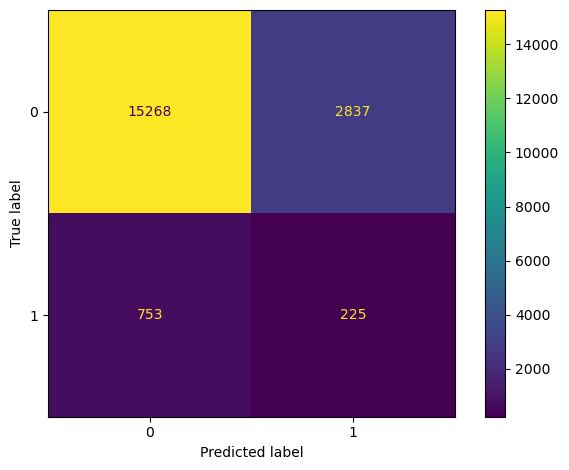

In [19]:
cm_test = confusion_matrix(y_test,y_pred)
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=clf.classes_)
display_cm.plot()
plt.tight_layout()
plt.show()

We have a considerable amount of False Positives (2844) VS False Negatives (759). <br> The model is way better at predicting True Negatives than True Positives. <br> Since the false positive implies the cost of sending an envelope and not receiving anything in return, it has a bigger impact in the business than receiving a donation without expecting it.

#

## Sklearn classification models are trained to maximize the accuracy. However, another error metric will be more relevant here. Please checkout make_scorer alogside with GridSearchCV in order to train the model to maximize the error metrics of interest in this case.

In [20]:
grid = {'max_depth': [5,10],
        'criterion': ['gini','entropy'],
        'min_samples_split': [20],
        'min_samples_leaf': [20]}

model = RandomForestClassifier()

grid_search = GridSearchCV(estimator = model, param_grid=grid, cv=5, scoring=make_scorer(cohen_kappa_score))

grid_search.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'min_samples_leaf': [20], 'min_samples_split': [20]},
             scoring=make_scorer(cohen_kappa_score))

In [21]:
print('Best parameters:', grid_search.best_params_)
print('Best kappa score:', round(grid_search.best_score_,4))

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 20}
Best kappa score: 0.8518


In [22]:
rfc = RandomForestClassifier(max_depth=10, criterion='gini', min_samples_split =20,
                             min_samples_leaf =20)
rfc.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=20)

In [23]:
y_pred = rfc.predict(X_test)
print(y_test.value_counts())

0    18105
1      978
Name: TARGET_B, dtype: int64


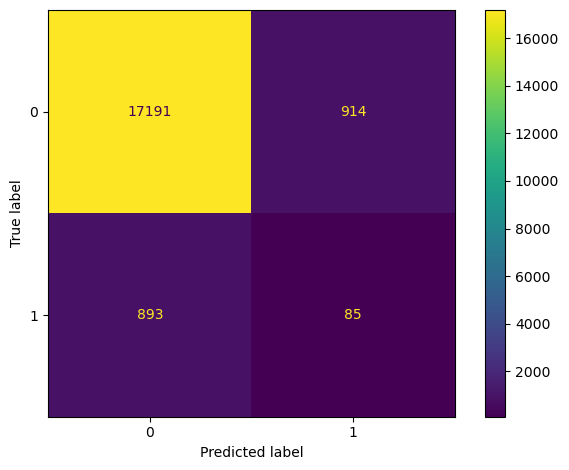

In [24]:
cm_test = confusion_matrix(y_test, y_pred)
display_cm = ConfusionMatrixDisplay(cm_test, display_labels=clf.classes_)
display_cm.plot()
plt.tight_layout()
plt.show()

False negatives have increased a bit, but we have reduced a lot the false positives (more than halved). True positives have decreased as well. Our model is better at predicting who will not donate.